In [1]:
import pandas as pd
import geopandas as gpd
from shapely import MultiPoint
import itertools
import os
import shutil
import zipfile
import subprocess

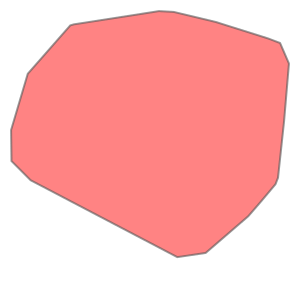

In [2]:
milan_buildings_polys = gpd.read_file("../data/footprints/Milano.shp").geometry
milan_buildings_points = [building.convex_hull.exterior.coords for building in milan_buildings_polys]
outer_milan = MultiPoint(list(itertools.chain.from_iterable(milan_buildings_points))).convex_hull.buffer(-1e-9)
gpd.GeoDataFrame(pd.DataFrame([{"id": "0"}]), geometry=[outer_milan],crs="EPSG:7791").to_file("../data/coverage.shp")
outer_milan

In [ ]:
sample_input_gdf = gpd.read_file("../data/coverage.shp").to_crs("EPSG:4326")
sample_coverage = list(sample_input_gdf["geometry"])[0]
CONTRACT_NUMBER = 145

# Specify intersection
contract_data = gpd.read_file(f"metadata/contract_{CONTRACT_NUMBER}/metadata_contract_{CONTRACT_NUMBER}.shp")

def get_intersection_tiles(input_polygon, lidar_coverage):
    intersection_array = lidar_coverage.geometry.map(lambda x: x.intersects(input_polygon))
    return lidar_coverage[intersection_array][["id", "region"]]

intersection = get_intersection_tiles(sample_coverage, contract_data)

# Copy files from HDD
source_path_prefix = "/Volumes/Seagate Expansion Drive/just_points"
destination_path_prefix = "../data/lidar_points/raw"

def get_point_file_path(region, contract, filename):
    return os.path.join(source_path_prefix, region, f"Contratto_{contract}", "PUNTI", f"{filename}.zip")

files_to_copy = [get_point_file_path(row["region"], str(CONTRACT_NUMBER), row["id"]) for _, row in intersection.iterrows()]
for filepath in files_to_copy:
    dst = os.path.join(destination_path_prefix, filepath.split("/")[-1])
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy(filepath, dst)

# Extract Zips
for filename in os.listdir(destination_path_prefix):  
    filepath = os.path.join(destination_path_prefix, filename)
    if zipfile.is_zipfile(filepath):
        with zipfile.ZipFile(filepath) as item:
           item.extractall(destination_path_prefix) 

# Remove Zips
for filename in os.listdir(destination_path_prefix): 
    if filename.endswith("zip"):
        os.remove(os.path.join(destination_path_prefix, filename))


In [2]:
footprints_raw = gpd.read_file("../data/footprints/Milano.shp").to_crs("EPSG:4326")
coverage_140 = gpd.read_file("../metadata/contract_140/metadata_contract_140.shp")
coverage_145 = gpd.read_file("../metadata/contract_145/metadata_contract_145.shp")

def prepare_points(points_filename):
    points = pd.read_csv(f"../data/lidar_points/{points_filename}.xyz", names=["long","lat","elevation","_1","_2"], delim_whitespace=True)
    points = points[["long","lat", "elevation"]].rename(columns={'lat': 'x', 'long': 'y', 'elevation': 'z'})
    points.insert(0, 'id', range(0, len(points)))
    path = f"../data/tmp/points_{points_filename}.csv"
    points.to_csv(path, index=False)
    return path

def prepare_footprints(points_filename):
    coverage_tiles_140 = list(coverage_140[coverage_140["id"] == points_filename].geometry)
    coverage_tiles_145 = list(coverage_145[coverage_145["id"] == points_filename].geometry)
    
    coverage_tile = coverage_tiles_140[0] if coverage_tiles_140 else coverage_tiles_145[0]
    footprints_intersection = footprints_raw.geometry.map(lambda x: x.intersects(coverage_tile))
    footprints = footprints_raw[footprints_intersection][["OBJECTID", "edifc_stat", "edifc_ty", "edifc_uso", "geometry"]]\
        .rename(columns={'OBJECTID': 'id'})
    path = f"../data/tmp/footprints_{points_filename}.csv"
    footprints.to_csv(path, index=False)
    return path

In [3]:
points_files = [f for f in os.listdir("../data/lidar_points/") if f.endswith("xyz")]
for filename in points_files: #['D45420917_0101_Punti.xyz']
    points_filename = filename[:-4]
    print(points_filename)
    if not f"{points_filename}.csv" in os.listdir("../data/postgis_output/"):
        points_path = prepare_points(points_filename)
        footprints_path = prepare_footprints(points_filename)
        output_path = f"../data/postgis_output/{points_filename}.csv"
        os.system(f"./postgis_processing.sh {points_path} {footprints_path} {output_path}")
        os.remove(footprints_path)
        os.remove(points_path)

D45440915_0101_Punti
D45500925_0101_Punti
D45470914_0101_Punti
D45420917_0101_Punti
D45490915_0101_Punti
D45410916_0101_Punti
D45450926_0101_Punti
D45510916_0101_Punti
D45520917_0101_Punti
D45460927_0101_Punti
D45480926_0101_Punti
D45430924_0101_Punti
D45490908_0101_Punti
D45470909_0101_Punti
D45440908_0101_Punti
D45410911_0101_Punti
D45490907_0101_Punti
D45490912_0101_Punti
D45420910_0101_Punti
D45470906_0101_Punti
D45470913_0101_Punti
D45500922_0101_Punti
D45440907_0101_Punti
D45440912_0101_Punti
D45510919_0101_Punti
D45520918_0101_Punti
D45400922_0101_Punti
D45430923_0101_Punti
D45480921_0101_Punti
D45460920_0101_Punti
D45520910_0101_Punti
D45510911_0101_Punti
D45450921_0101_Punti
D45420918_0101_Punti
D45410919_0101_Punti
D45450920_0101_Punti
D45510910_0101_Punti
D45520911_0101_Punti
D45460921_0101_Punti
D45430922_0101_Punti
D45480920_0101_Punti
D45400923_0101_Punti
D45410918_0101_Punti
D45420919_0101_Punti
D45440913_0101_Punti
D45440906_0101_Punti
D45500923_0101_Punti
D45470912_010

Error response from daemon: remove 6171f82d3368cefa8b3fb174f1908c5a7f720a4a1970add2523b95b444066d4d: volume is in use - [080f6eb47644ac247c58d1cc6c830327064418a3e2ecb915bcb37d840f69483f]
docker: Error response from daemon: Conflict. The container name "/skynet" is already in use by container "080f6eb47644ac247c58d1cc6c830327064418a3e2ecb915bcb37d840f69483f". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.
Error response from daemon: Container 080f6eb47644ac247c58d1cc6c830327064418a3e2ecb915bcb37d840f69483f is not running


skynet
skynet
D45410922_0101_Punti
6171f82d3368cefa8b3fb174f1908c5a7f720a4a1970add2523b95b444066d4d
5434c4f207a2c852fd9116df78f5961db5db07f5ed6f7dc1bacc38d91e72840d
CREATE TABLE
CREATE TABLE
COPY 1384898
UPDATE 1384898
COPY 13
UPDATE 13
UPDATE 13
COPY 13
skynet
skynet
D45440921_0101_Punti
b04c1a374c0fdb8783c684b80235c1cd9bac513e75e921e31c04d06102776478
dfbf2aa9be615bae8b164d1ec07f1606c48c1714d30d9d7d3e1d8645e217bb2d
CREATE TABLE
CREATE TABLE
COPY 1686497
UPDATE 1686497
COPY 712
UPDATE 712
UPDATE 712


In [1]:
points_files = [f[:-4] for f in os.listdir("../data/lidar_points/") if f.endswith("xyz")]
output_files = [f[:-4] for f in os.listdir("../data/postgis_output/") if f.endswith("csv")]


def count_items(list1, list2): 
    count = 0 
    for item in list1: 
        if item in list2: 
            count += 1 
    return count

count_items(output_files, points_files)

267